## Objective:
- Understand when and why employees are most likely to leave (people analytics)
- Build a model to predict employee retention
- Create a table with date, employee_headcount (# employed on that specific day), company_id
- Derive main driving factors for employee churn
- Consider potential additional variables that can aid in predicting employee retention

In [1]:
# Import the necessary libraries

# Import pandas and numpy
import numpy as np
import pandas as pd

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Import datetime
import datetime

# Import itertools
import itertools

# Import stats from scipy
from scipy import stats

In [2]:
# Import the raw data
raw_df = pd.read_csv('employee_retention_data.csv')

Let's make sure that the data is valid.
- Employee IDs shoudl be unique in the dataset
- Expect null values in quit_date if the employee has not left

In [3]:
# Check for null values
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [4]:
# Make sure employee ids are unique
assert raw_df['employee_id'].nunique() == len(raw_df)

In [5]:
# Show summary statistics
raw_df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [6]:
# Since the employee_id are indeed unique, I will set them as the index to the dataset

# Convert the employee ids to dtype int
raw_df = raw_df.astype({'employee_id':'int64'})

# Set the employee_id as index
raw_df.set_index('employee_id', inplace=True)

Notes:
- Slightly more than half of the employees have quit their positions
- Although unique, employee ids are not sequential between 36 to 999969
- There appears to be an outlier in seniority, where seniority = 99 (99 years of work experience?)
- Although there does appear to be an outlier for salary (408,000), the value is within the possible ranges for higher positioned employees.
- The join_date and quit_date entries are dtype objects.

In [7]:
# Take a closer look at the seniority outlier
raw_df.sort_values('seniority', ascending=False).head()

,company_id,dept,seniority,salary,join_date,quit_date
employee_id,,,,,,
604052,1,marketing,99,185000.0,2011-07-26,2013-12-06
97289,10,engineer,98,266000.0,2011-12-13,2015-01-09
426218,2,customer_service,29,118000.0,2011-03-02,2013-07-12
889253,2,engineer,29,318000.0,2011-09-12,NaN
664204,8,marketing,29,147000.0,2014-02-03,2015-02-20


There appears to be two invalid entries in this case (seniority in [98, 99]). At this point, I can choose to remove them completely, or impute appropriate values for them. 

In [8]:
# Take a closer look at the salary distribution
raw_df.sort_values('salary', ascending=False).head(10)

,company_id,dept,seniority,salary,join_date,quit_date
employee_id,,,,,,
62540,2,engineer,23,408000.0,2013-08-26,NaN
517439,2,engineer,25,406000.0,2013-09-16,NaN
965750,1,data_science,19,398000.0,2015-05-04,NaN
707585,1,engineer,22,393000.0,2013-09-16,NaN
460908,1,engineer,24,386000.0,2014-11-03,NaN
820823,1,data_science,23,381000.0,2014-11-03,NaN
324366,2,data_science,26,381000.0,2014-12-17,NaN
921637,1,engineer,16,379000.0,2012-09-17,2015-09-25
962125,1,data_science,26,378000.0,2011-12-19,2014-08-29


It appears that company_id = 1 and company_id = 2 compensate their engineers and data scientists very well. I will make no changes to the higher values for salary.

In [9]:
# Check the dept column for any odd values
raw_df['dept'].unique()

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

In [10]:
# Create an intermediate table with the extreme seniority values removed
int_df = raw_df.drop([604052, 97289])

# Convert the join_date and quit_date to datetime objects
int_df['join_date'] = pd.to_datetime(int_df['join_date'])
int_df['quit_date'] = pd.to_datetime(int_df['quit_date'])

In [11]:
# Make sure only two rows were removed
assert (len(int_df) + 2) == len(raw_df)

In [12]:
# Make sure that the data is within the specified date range (2011-01-24 to 2015-12-13)

# Define the start date and end dates
end_date = datetime.datetime.strptime('2015-12-13', '%Y-%m-%d')
start_date = datetime.datetime.strptime('2011-01-24', '%Y-%m-%d')

# start_date = datetime.date(2015, 12, 13)
# end_date = datetime.date(2011, 1, 24)

# Check the max of the join date
assert int_df['join_date'].max() <= end_date

# Check the min of the join date
assert int_df['join_date'].min() >= start_date

# Repeat the same process for quit_dates

# Check the max of the quit date
assert int_df['quit_date'].max() <= end_date

# Check the min of the quit date
assert int_df['quit_date'].min() >= start_date

In [13]:
# Define a new dataframe with the desired columns

unique_dates = pd.date_range(start=start_date, end=end_date)
unique_columns = sorted(int_df['company_id'].unique())

# Define an empty dataframe to add columns into
daily_employed = pd.DataFrame({'day':unique_dates, 'key':0})

# Add a day column for each date between the start and end dates
# daily_employed['day'] = pd.date_range(start=start_date, end=end_date)

In [14]:
# Define lists for the unique dats and companies
unique_dates = pd.date_range(start=start_date, end=end_date).tolist()
unique_companies = sorted(int_df['company_id'].unique())

# Assign the cartesian product (cross join) to a variable
result = itertools.product(unique_dates, unique_companies)

# Create empty lists to hold the dates and companies
date_list = []
company_list = []

# Iterate over the result and append each value to their respective lists
for i in result:
    date_list.append(i[0])
    company_list.append(i[1])

In [15]:
# Create a working dataframe to calculate the daily employed
working_df = pd.DataFrame({'day':date_list, 'company_id':company_list})

# Merge the working dataframe to the employee dataset (cross join)
working_df = working_df.merge(int_df, on='company_id', how='left')

In [16]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44089500 entries, 0 to 44089499
Data columns (total 7 columns):
company_id    int64
day           datetime64[ns]
dept          object
seniority     int64
salary        float64
join_date     datetime64[ns]
quit_date     datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(2), object(1)
memory usage: 2.6+ GB


In [17]:
# Make sure no dates we lost
assert working_df['day'].nunique() == len(unique_dates)

# Note that there may be dates where there are no employees in a particular company

In [18]:
# Leave only employees that occur between date
working_df = working_df[(working_df['day'] >= working_df['join_date']) & 
                        (working_df['day'] <= working_df['quit_date'])].copy()

# Create a employee_headcount column for summing during groupby
working_df['employee_headcount'] = 1

In [19]:
# Group the data by day and company_id, and take a headcount of employees
daily_employed = working_df.groupby(['day', 'company_id']).agg({'employee_headcount':sum}).reset_index()

In [20]:
# Display the head of the desired table
daily_employed.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


Now that I've created the desired table, I will return to the intermediate table to analyze churn rate.

First I will create an additional column for length of employment. Next, I need a target variable to indicate if the employee has left or not.

In [21]:
# Define a column for days employed
int_df['days_employed'] = (int_df['quit_date'] - int_df['join_date']).dt.days

# Fill the null values in days employed with -1's to represent they haven't quit
int_df['days_employed'].fillna((end_date - int_df['join_date']).dt.days, inplace=True)

# Create a target column with 1 for old employee and 0 for current employee
int_df['churn'] = 1
int_df.loc[int_df['quit_date'].isnull(), 'churn'] = 0

I'll run some inferential statistics on the current and old employees to see if there are any statistically significant differences between them (numerical and categorical).

For this, I will run two-sided t-test for the numerical columns and chi-squared tests for the categorical columns (p-value < 0.05).

Null Hypothesis: There are no differences between the past and current employees during this time period.

Alternate Hypothesis: There are differences between the past and current employees during this time period.

In [22]:
# Define a dataframe for the employees that quit
old_employees = int_df[int_df['churn'] == 1].copy()

# Define a dataframe for the current employees
current_employees = int_df[int_df['churn'] == 0].copy()

In [23]:
# Make sure the dataframes are properly split and no rows are dropped
assert (len(old_employees) + len(current_employees)) == len(int_df)

In [24]:
# Define a list of numerical columns
NUMERICAL = ['seniority', 'salary', 'days_employed']

# Define a list of categorical variables
CATEGORICAL = ['company_id', 'dept']

In [25]:
# Apply two-sided t-test to the numerical columns
for col in NUMERICAL:
    result = stats.ttest_ind(old_employees[col], current_employees[col])
    print('{}: {}'.format(col, result))

seniority: Ttest_indResult(statistic=-0.04298362740450958, pvalue=0.9657149327010423)
salary: Ttest_indResult(statistic=-5.763520586411431, pvalue=8.335694924613824e-09)
days_employed: Ttest_indResult(statistic=18.825437588630404, pvalue=1.6581403916833545e-78)


In [26]:
# Apply chi-squared tests to the categorical columns
for col in CATEGORICAL:
    cont_table = pd.crosstab(int_df['churn'], int_df[col])
    score, p_value, dof, array = stats.chi2_contingency(cont_table)
    print ('X-squared for {}: X-Score:{}    p-value:{}'.format(col, score, p_value))

X-squared for company_id: X-Score:19.01931996696012    p-value:0.06074759035554246
X-squared for dept: X-Score:42.32790836528519    p-value:5.0556024084381965e-08


It appears that there are no significant differences in seniority and company id for employees that stayed and employees that left. Let's provide some visualizations for this data.

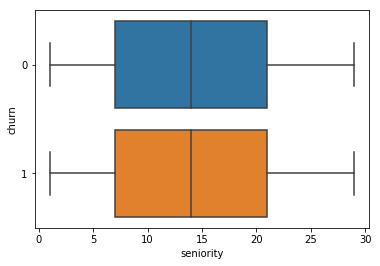

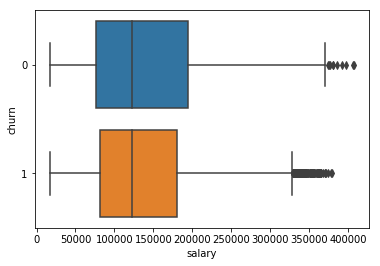

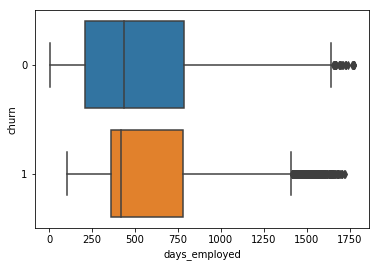

In [27]:
# Use boxplots to visualize the distribution of the data
for col in NUMERICAL:
    sns.boxplot(x=col, y='churn', data=int_df, orient='h')
    plt.show()

In [28]:
# Let's compliment the results with bootstrapping and 95% confidence intervals

# Define a function for bootstrapping
def bootstrap(cat, num):
    '''Returns [num] bootstrap means of specified category'''
    # Create [num] instances of empty arrays for low_train, high_train to contain the bootstrap samples
    old_employ_bootstrap = np.empty(num)
    current_employ_bootstrap = np.empty(num)

    for i in range(num):
        # Define the bootstrap samples and store them in the empty arrays 
        old_employ_bootstrap[i] = np.mean(np.random.choice(old_employees[cat], len(old_employees)))
        current_employ_bootstrap[i] = np.mean(np.random.choice(current_employees[cat], len(current_employees)))
        
    return old_employ_bootstrap, current_employ_bootstrap


seniority:
95% Confidence Interval for Churned Employees: [13.98516065 14.25111415]
95% Confidence interval for Current Employees: [13.97698579 14.2735168 ]


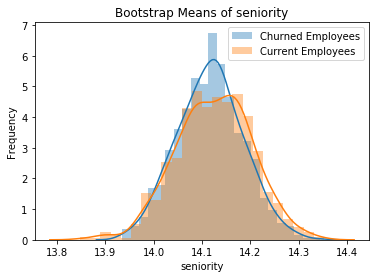


salary:
95% Confidence Interval for Churned Employees: [134391.57351199 136831.57203139]
95% Confidence interval for Current Employees: [139777.40796998 142801.86293781]


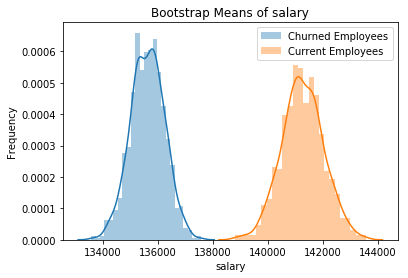


days_employed:
95% Confidence Interval for Churned Employees: [607.53054486 618.60471017]
95% Confidence interval for Current Employees: [519.98284042 533.84209703]


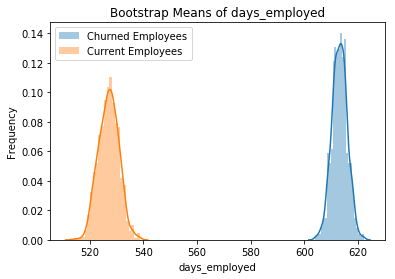

In [29]:
# Iterate over the values in the NUMERICAL list
for col in NUMERICAL:
    
    # Define 100 bootstrap samples for each category
    old_repl, current_repl = bootstrap(col, 1000)
    
    # Define the confidence intervals
    confidence_interval_old = np.percentile(old_repl, [2.5, 97.5])
    confidence_interval_current = np.percentile(current_repl, [2.5, 97.5])
    
    # Print the results
    print ('\n{}:'.format(col))
    print ('95% Confidence Interval for Churned Employees:', confidence_interval_old)
    print ('95% Confidence interval for Current Employees:', confidence_interval_current)
    
    # Plot the samples
    sns.distplot(old_repl, label='Churned Employees')
    sns.distplot(current_repl, label='Current Employees')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Bootstrap Means of {}'.format(col))
    plt.legend()
    plt.show()

Excluding the outliers (by taking the means), trends to note:
- Churned employees, on average, are paid less.
- Churned employees, on average, are employed for a quarter of a year longer.

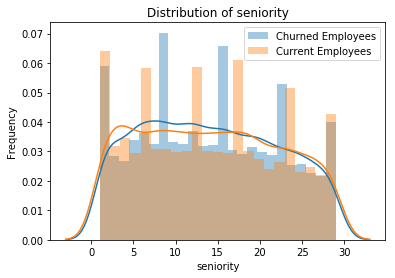

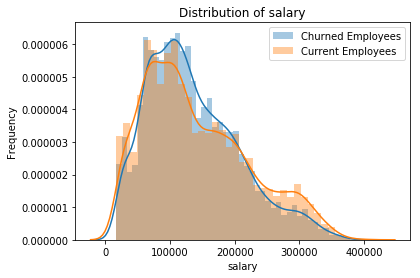

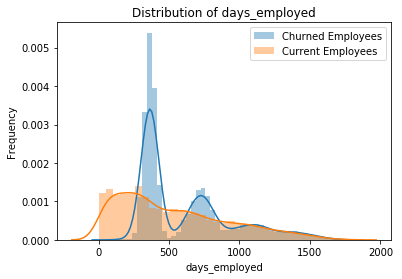

In [30]:
# Also provide the regular distribution

# Iterate over the values in the NUMERICAL list
for col in NUMERICAL:
    # Plot the samples
    sns.distplot(old_employees[col], label='Churned Employees')
    sns.distplot(current_employees[col], label='Current Employees')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))
    plt.legend()
    plt.show()

Without removing outliers, most noteworthy:
- There are two distinct peaks (ranges of time employed) that churned employees fall under
    - Most churned employees leave slightly after 1 year or slightly after 2 years.

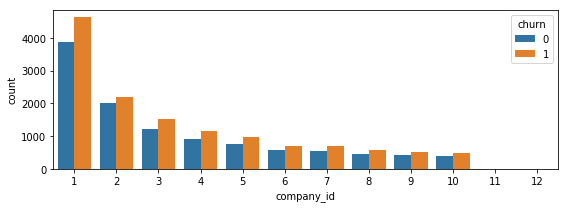

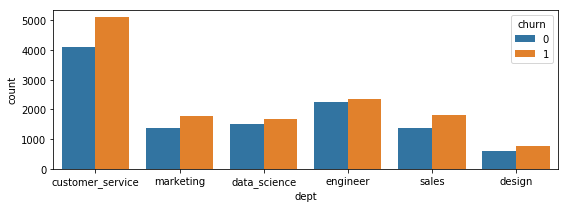

In [31]:
# Use countplots to show the occurrence of each value
for col in CATEGORICAL:
    plt.figure(figsize=(8,3))
    sns.countplot(x=col, hue='churn', data=int_df)
    plt.tight_layout()

Noteworthy:
- Total number of employees appears to decrease with increasing company_id (the two should be independent as company_id is a categorical variable and there is no inter-correlation between the ids)
- The customer service department appears to have the most employees and the lowest retention rate.

Let's verify these findings numerically.

In [32]:
# Display summary statistics
int_df.describe()

,company_id,seniority,salary,days_employed,churn
count,24700.000000,24700.000000,24700.000000,24700.000000,24700.000000
mean,3.426802,14.120972,138176.275304,574.285142,0.546883
std,2.699752,8.054137,76056.331953,361.585465,0.497807
min,1.000000,1.000000,17000.000000,3.000000,0.000000
25%,1.000000,7.000000,79000.000000,333.000000,0.000000
50%,2.000000,14.000000,123000.000000,424.000000,1.000000
75%,5.000000,21.000000,187000.000000,781.000000,1.000000
max,12.000000,29.000000,408000.000000,1777.000000,1.000000


In [33]:
# Let's first take a look at the change in seniority, salary, and days employed across the departments
dept_df = int_df.groupby(['dept', 'churn']).agg({'seniority':'mean', 'salary':'mean', 'days_employed':'mean'})
dept_df

seniority         salary  days_employed
dept             churn                                         
customer_service 0      13.715859   79656.387665     510.813754
                 1      14.536317   84322.143698     602.242638
data_science     0      14.959549  215387.931034     557.329576
                 1      13.498216  199263.376932     650.760999
design           0      13.720930  134325.581395     535.117940
                 1      14.566838  139886.889460     602.813625
engineer         0      14.703243  212515.326522     553.454909
                 1      13.630241  198872.935197     649.129606
marketing        0      13.770954  134213.150289     506.236272
                 1      14.118967  136645.903479     600.704826
sales            0      13.997796  136277.002204     516.080823
                 1      13.966317  135638.321369     580.770845

In [34]:
# Calculate the churn rate for each department
dept_df = int_df.groupby('dept').agg({'churn':'mean'})
dept_df

,churn
dept,
customer_service,0.554902
data_science,0.527273
design,0.563768
engineer,0.511925
marketing,0.562855
sales,0.570933


It appears that in all departments ,there is a >50% churn rate, with sales being the greatest at (~57%). Data science and engineering departments have the lowest churn rates (~52.7% and ~51.2% respectively). To complement that, those two departments have the largest pay gap between churned employees and current employees.

In [35]:
# Calculate the churn rate for each company
company_df = int_df.groupby('company_id').agg({'churn':'mean'})
company_df

,churn
company_id,
1,0.544490
2,0.522501
3,0.556930
4,0.559166
5,0.560114
6,0.551510
7,0.565359
8,0.553009
9,0.550468


In [36]:
# Take a closer look at company_id=11 and 12 with the greatest and lowest churn rates
company_df = int_df.groupby(['company_id', 'churn']).agg({'seniority':'mean', 'salary':'mean', 'days_employed':'mean'})
company_df.loc[[11,12]]

seniority    salary  days_employed
company_id churn                                    
11         0      11.500000   55000.0     812.500000
           1      15.333333  127750.0     550.416667
12         0      11.166667   75250.0     638.000000
           1      11.166667   70750.0     465.166667

There isn't anything particularly strange about company 12. However, company 11 has the largest pay differential between current and churned employees. In particular, current employees are, on average, paid far less.

In [37]:
company_dept = int_df.groupby(['company_id', 'dept', 'churn']).agg({'seniority':'mean', 'salary':'mean', 'days_employed':'mean'})
company_dept.loc[[11]]

seniority         salary  days_employed
company_id dept             churn                                         
11         customer_service 0      14.666667   58333.333333     677.666667
                            1       5.666667   27333.333333     367.666667
           data_science     1      16.500000  153500.000000     693.000000
           engineer         0       2.000000   45000.000000    1217.000000
                            1      17.600000  179000.000000     485.800000
           marketing        1      23.000000  124500.000000     843.500000

There are only churned employees for the data science and marketing departments. Let's take a look at employee headcount for company 11.

In [38]:
daily_employed.groupby('company_id').sum()

,employee_headcount
company_id,
1,2850980
2,1389118
3,934868
4,692527
5,599928
6,430400
7,422713
8,343904
9,329642


Company 11 and 12 have the smallest number of employees. The sample size can cause skewed data in these two.

Before moving on, it may be worth checking if the time of the year affects churn rates. As a result , I will generate 4 new variables (year and month for the join date and quit dates).

In [39]:
# ASsign a copy of the dataframe to another variable
time_df = int_df.copy()

# Derive the start year
time_df['join_year'] = time_df['join_date'].dt.year

# Derive the start month
time_df['join_month'] = time_df['join_date'].dt.month

# Derive the end year
time_df['quit_year'] = time_df['quit_date'].dt.year

# Derive the end month
time_df['quit_month'] = time_df['quit_date'].dt.month

# Define a list of time variables
TIME = ['join_year', 'join_month', 'quit_year', 'quit_month']

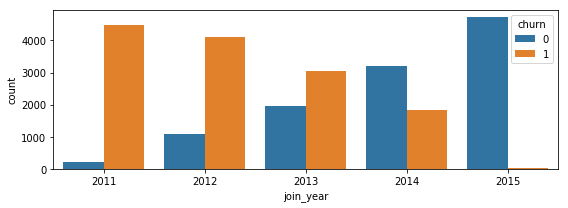

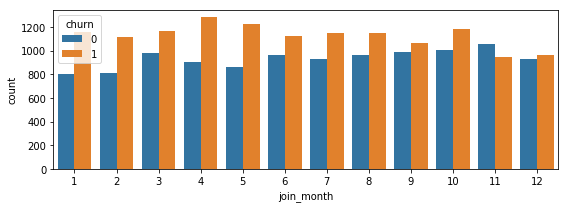

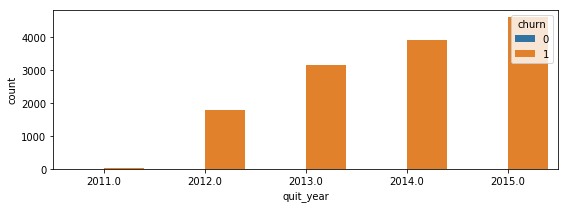

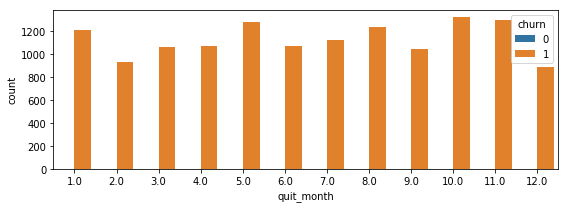

In [40]:
# Use countplots to show the occurrence of each value
for col in TIME:
    plt.figure(figsize=(8,3))
    sns.countplot(x=col, hue='churn', data=time_df)
    plt.tight_layout()

Noteworthy:
- Most employees from 2011 have left by 2015 (it appears like it is the norm to leave after a certain amount of time).
- There is lower employee churn from employees that start around November and December.
- Least number of employees leave their positions in December.

## Summary:
- The greatest driving factor for employee churn is the length of employment and the salary.
    - Most employees leave their position slightly after 1 year or slightly after 2 years of employement.
    - Churned employees, on average, are paid less than their counterparts.

Let's build a model that can predict employee churn. Since I am working with a binary classification (churn or not), I will be using the RandomForestClassifier which can accommodate for the "outliers" in the salary and days_employed numerical variables.

I will be leaving out particular variables that would skew the model (ex. quit_date explicitly relays churn as non-null values).
- join_date, quit_date, join_year, quit_year, quit_month

In [41]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Import train_test_split
from sklearn.model_selection import train_test_split

In [42]:
# Redefine the dataframe with the columns of interest
processed_df = time_df[['company_id', 'dept', 'seniority', 'salary', 'days_employed', 'churn', 'join_month']].copy()

In [43]:
time_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24700 entries, 13021 to 777612
Data columns (total 12 columns):
company_id       24700 non-null int64
dept             24700 non-null object
seniority        24700 non-null int64
salary           24700 non-null float64
join_date        24700 non-null datetime64[ns]
quit_date        13508 non-null datetime64[ns]
days_employed    24700 non-null float64
churn            24700 non-null int64
join_year        24700 non-null int64
join_month       24700 non-null int64
quit_year        13508 non-null float64
quit_month       13508 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(5), object(1)
memory usage: 3.1+ MB


In [44]:
# Append join month to the list of categorical variables
CATEGORICAL.append('join_month')

# Apply LabelEncoder to the dept variable
processed_df['dept'] = LabelEncoder().fit_transform(processed_df['dept'])

In [45]:
processed_df.head()

,company_id,dept,seniority,salary,days_employed,churn,join_month
employee_id,,,,,,,
13021,7,0,28,89000.0,585.0,1,3
825355,7,4,20,183000.0,340.0,1,4
927315,4,4,14,101000.0,426.0,0,10
662910,7,0,20,115000.0,389.0,1,5
256971,2,1,23,276000.0,1040.0,1,10


In [46]:
# Define the X and y data
X = processed_df.drop(['churn'], axis=1)
y = processed_df['churn']

# Create the dummy variables and remove the original column from the X data
for col in CATEGORICAL:
    group_dummies = pd.get_dummies(X[col]).rename(columns=lambda x: col + str(x))
    X = X.join(group_dummies)
    del X[col]

# Split the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [47]:
# Instantiate the RandomForestClassifier with 200 estimators
rf = RandomForestClassifier(n_estimators=200)

# Fit the model with the data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

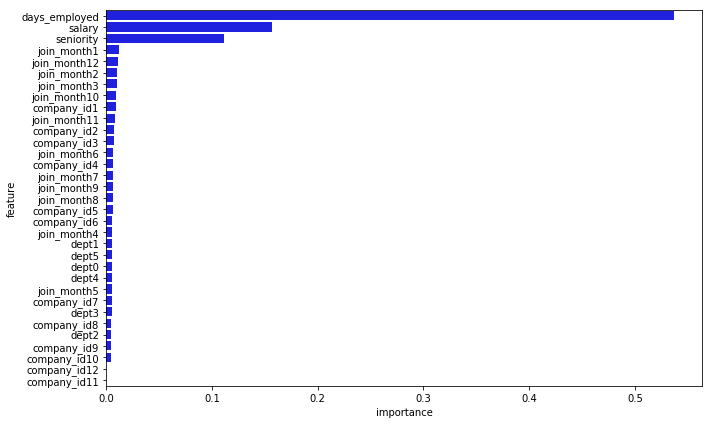

In [48]:
# Extract the feature importances and zip it with the columns into a dataframe# Extrac 
importances = rf.feature_importances_
features = pd.DataFrame({'feature': X.columns, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=features['importance'], y=features['feature'], color='blue', orient='h')
plt.tight_layout()

In [49]:
# Predit the test data
predicted_test = rf.predict_proba(X_test)[:, -1]

print ('Score:     {}'.format(roc_auc_score(y_test, predicted_test)))

Score:     0.9274121626113547


In [50]:
# Predict the full conversion rate
predicted_churn_rate = predicted_test.sum() / len(predicted_test)

# print the final result
print ('Predicted Employee Churn Rate: {:.2f}%'.format(predicted_churn_rate * 100))
print ('Actual Churn Rate: {:.2f}%'.format(np.mean(y_test) * 100))

Predicted Employee Churn Rate: 54.83%
Actual Churn Rate: 55.87%


## Conclusion:
- Using RandomForestClassifier, it appers that the model predicts employee churn rate fairly well. The model puts the most weight on the length of employment, salary, and seniority (all the numerical columns). With categorical variables, the most weight is put on the month that the employee joined.
- Length of employment has high impact for predicting churn rate. In particular, employees leave around the end of their first or second years.
- Increased salary, relative to the department, reduces churn rate.
- I believe a beneficial variable to have is difference in compensation during length of employment. I feel most employees leave their current position due to lack of vertical growth. 